In [22]:
import nidaqmx
import nidaqmx.stream_readers
import numpy as np
import matplotlib.pyplot as plt
import csv

In [23]:
from scipy import stats

In [296]:
# def plot_xy_line2(title, xlabel, ylabel1, ylabel2, xdata, y1, y2, marker=None):
#     fig, ax = plt.subplots()
#     ax.set_title(title)
#     ax.set_xlabel(xlabel)
#     ax.set_ylabel("Voltage [V]")
#     ax.plot(xdata, y1, label=ylabel1)
#     if marker == None:
#         ax.plot(xdata, y2, label=ylabel2)
#     else:
#         ax.plot(xdata, y2, label=ylabel2, marker='o', markevery=marker)
#     ax.plot()
#     ax.legend()

# # CMD and POS
# def plot_cmd_pos(f, t, cmd, pos):
#     fig, ax = plt.subplots()
#     ax.set_title("Galvo scanner response to command wave (" + str(f) + "Hz)")
#     ax.set_xlabel("Time [s]")
#     ax.set_ylabel("Voltage [V]")
#     ax.plot(t, cmd, label="cmd")
#     ax.plot(t, pos, label="pos")
#     ax.plot()

In [556]:
# Plotting

# Galvo waveform
def plot_galvo(title, xlabel, ylabel, data):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(data)

def plot_xy_scatter(title, xlabel, ylabel, xdata, ydata):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.scatter(xdata, ydata)
    
def plot_line(xdata, y1, freq=None, title=None, xlabel="Time [s]", ylabel="Voltage [V]", ylabel1=None, ylabel2=None, ylabel3=None, y2=None, y3=None, markers=None):
    fig, ax = plt.subplots()
    if title == None:
        if freq == None:
            ax.set_title("Galvo scanner response to command wave")
        else:
            ax.set_title("Galvo scanner response to command wave (" + str(freq) + "Hz)")
    else:
        ax.set_title(title)
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
        
    if markers == None:
        if ylabel1 == None:
            ax.plot(xdata, y1)
        else:
            ax.plot(xdata, y1, label=ylabel1)
    else:
        if ylabel1 == None:
            ax.plot(xdata, y1, marker='o', markevery=markers)
        else:
            ax.plot(xdata, y1, label=ylabel1, marker='o', markevery=markers)
    
    # print(isinstance(y2, list))
    if y2 is not None:
        ax.plot(xdata, y2, label=ylabel2)
        if y3 is not None:
            ax.plot(xdata, y3, label=ylabel3)
        ax.legend()
    ax.plot()

# CMD and POS from 0 to 0.5 seconds
def plot_cmd_pos_zoom(t, cmd, pos):
    fig, ax = plt.subplots()
    ax.set_title("Galvo scanner response to command wave zoomed in")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Voltage [V]")
    ax.plot(t[:2500], cmd[:2500], label="cmd")
    ax.plot(t[:2500], pos[:2500], label="pos")
    ax.legend()

In [110]:
def write_to_csv(name, x, y):
    file = open(name + ".csv", "w")
    writer = csv.writer(file)

    for w in range(len(cmd)):
        writer.writerow([x[w], y[w]])
    file.close()

def write_to_csv2(name, t, cmd, pos):
    file = open(name + ".csv", "w")
    writer = csv.writer(file)

    for w in range(len(cmd)):
        writer.writerow([t[w], cmd[w], pos[w]])
    file.close()

In [111]:
# Galvo Parameters to change

zoom = 1
undershoot = 50
pixelsPerLine = 256 #100
linesPerFrame = 256 #100
X_RETRACE_LEN = 128

In [476]:
# Generating Waveform

def SplineInterpolate(n, yFirst, yLast, slopeFirst, slopeLast):
    m = float(n)
    mm = float(m * m)
    mmm = float(m * m *m)
    c = []
    c.append(slopeFirst / mm + 2.0 * yFirst / mmm + slopeLast / mm - 2.0 * yLast / mmm)
    c.append(3.0 * yLast / mm - slopeLast / m - 2.0 * slopeFirst / m - 3.0 * yFirst / mm)
    c.append(slopeFirst)
    c.append(yFirst)
    
    result = []
    n = int(n)
    for i in range(n):
        result.append(c[0] * i*i*i + c[1] * i*i + c[2] * i + c[3])
    return result

def GenerateXWaveform(scanLen, retraceLen, undershootLen, scanStart, scanEnd):
    waveform = []
    scanAmp = scanEnd - scanStart
    step = scanAmp/scanLen
    linearLen = undershootLen + scanLen
    undershootStart = scanStart - undershootLen * step
    for i in range(linearLen):
        val = undershootStart + step * i
        waveform.append(val)
    if retraceLen > 0:
        splineWaveform = SplineInterpolate(retraceLen, scanEnd, undershootStart, step, step)
        completeWaveform = waveform + splineWaveform
    return completeWaveform

def GenerateYWaveform(linesPerFrame, retraceLen, xLength, scanStart, scanEnd):
    scanAmp = scanEnd - scanStart
    step = scanAmp/linesPerFrame
    waveform = np.zeros(linesPerFrame * xLength)
    
    if retraceLen > 0:
        splineWaveform = SplineInterpolate(retraceLen, scanEnd, scanStart, 0, 0)
    for j in range(linesPerFrame):
        for i in range(xLength):
            waveform[i + j * xLength] = scanStart + step * j
            nextIndex = i + j * xLength
            if j >= (linesPerFrame - 1) and i >= (xLength - X_RETRACE_LEN):
                break
    
    if retraceLen > 0:
        splineWaveform = SplineInterpolate(retraceLen, scanEnd, scanStart, 0, 0)
        for i in range(X_RETRACE_LEN):
            waveform[nextIndex + i] = splineWaveform[i]
    return waveform

def GenerateGalvoFrame(width, height, resolution, zoom, undershoot, xOffset, yOffset, galvoX, galvoY):
    xStart = (-0.5 * resolution + xOffset) / (zoom * resolution)
    yStart = (-0.5 * resolution + yOffset) / (zoom * resolution)
    xEnd = xStart + pixelsPerLine / (zoom * resolution)
    yEnd = yStart + linesPerFrame / (zoom * resolution)
    
    offsetXinDegree = galvoX / 3.0
    offsetYinDegree = galvoY / 3.0
    xLength = undershoot + pixelsPerLine + X_RETRACE_LEN
    yLength = linesPerFrame
    
    xWaveformFrame = GenerateXWaveform(pixelsPerLine, X_RETRACE_LEN, undershoot, xStart, xEnd)
    yWaveformFrame = GenerateYWaveform(linesPerFrame, X_RETRACE_LEN, xLength, yStart, yEnd)
    waveformFrame = np.zeros(2 * xLength * yLength)
    fullXWaveformFrame = []
    for j in range(yLength):
        for i in range(xLength):
            waveformFrame[i + j * xLength] = (xWaveformFrame[i] + offsetXinDegree)
            waveformFrame[i + j * xLength + yLength * xLength] = (yWaveformFrame[i + j * xLength] + offsetYinDegree)
    return waveformFrame
                

In [475]:
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, zoom, undershoot, 0, 0, 0, 0)

0.1953125


Number of samples: 222208


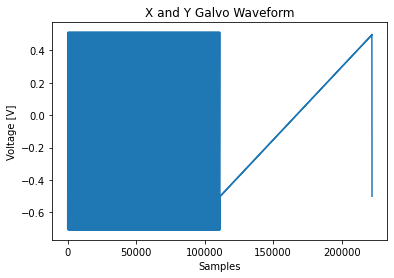

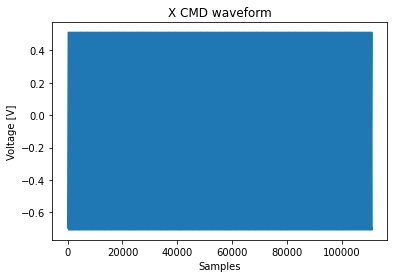

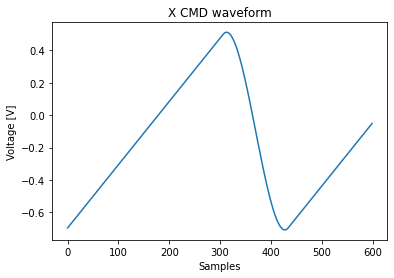

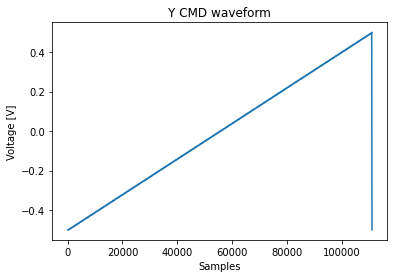

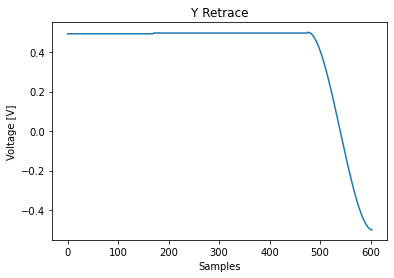

In [128]:
# X and Y frame
frameLength = len(frame)
print("Number of samples: " + str(frameLength))
plot_galvo("X and Y Galvo Waveform", "Samples", "Voltage [V]", frame)

# X frame
xFrame = frame[:int(frameLength / 2)]
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame)
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame[:600])

# Y frame
yFrame = frame[int(frameLength / 2):]
plot_galvo("Y CMD waveform", "Samples", "Voltage [V]", yFrame)
plot_galvo("Y Retrace", "Samples", "Voltage [V]", yFrame[110500:])

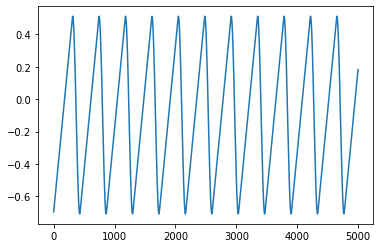

In [123]:
xFrame_waveform = xFrame[:5000]
plt.plot(xFrame_waveform)

In [124]:
# Scanner setting parameters

device = "Dev1"
aichan = "ai0"
aochan = "ao0"

In [125]:
# Writing to Scanner

def get_pos_waveform(waveform_segments):
    pos_waveform = np.concatenate(waveform_segments)
    return pos_waveform

def write_voltage_waveform(samp_rate, x_waveform):
    pos_waveform_segments = []  # list of 1D arrays
    
    # set parameters
    total_samples = 5000
    duration = total_samples / samp_rate
    t = np.linspace(0, duration, total_samples, endpoint=False)
    read_size = 1000  # samples
    cmd_waveform = x_waveform
    
    # Write to channels
    FINITE = nidaqmx.constants.AcquisitionType.FINITE
    with nidaqmx.Task() as intask:
        intask.ai_channels.add_ai_voltage_chan(f"{device}/{aichan}")
        intask.timing.cfg_samp_clk_timing(samp_rate, sample_mode=FINITE, samps_per_chan=total_samples)

        reader = nidaqmx.stream_readers.AnalogSingleChannelReader(intask.in_stream)
        def input_callback(task, event_type, n_samples, data):
            buffer = np.empty(n_samples)
            n_read = reader.read_many_sample(buffer, n_samples)
            pos_waveform_segments.append(buffer[:n_read])
            return 0
        intask.register_every_n_samples_acquired_into_buffer_event(read_size, input_callback)

        intask.triggers.start_trigger.cfg_dig_edge_start_trig(f"/{device}/ao/StartTrigger")
        intask.start()

        with nidaqmx.Task() as outtask:
            outtask.ao_channels.add_ao_voltage_chan(f"{device}/{aochan}")
            outtask.timing.cfg_samp_clk_timing(samp_rate, sample_mode=FINITE, samps_per_chan=total_samples)
            outtask.write(cmd_waveform, auto_start=True)
            outtask.wait_until_done()

        intask.wait_until_done()
        
    pos_waveform = get_pos_waveform(pos_waveform_segments)
    
    return t, cmd_waveform, pos_waveform

In [143]:
# input vs. output
t, cmd, pos = write_voltage_waveform(1e5, xFrame_waveform)

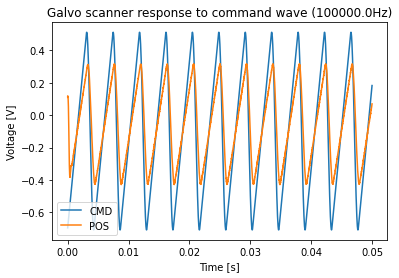

In [144]:
# 1e5 Hz

# plot_cmd_pos(1e5, t, cmd, pos)
plot_line(t, cmd, freq=1e5, ylabel1="CMD", ylabel2="POS", y2=pos)

In [136]:
t2, cmd2, pos2 = write_voltage_waveform(5e4, xFrame_waveform)

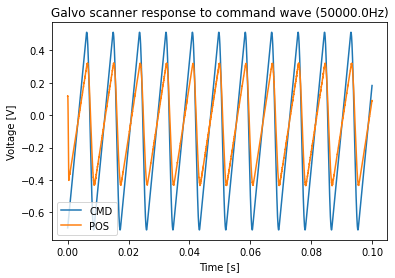

In [138]:
# 5e4 Hz

plot_line(t2, cmd2, freq=5e4, ylabel1="CMD", ylabel2="POS", y2=pos2)

In [146]:
t3, cmd3, pos3 = write_voltage_waveform(1.25e5, xFrame_waveform)

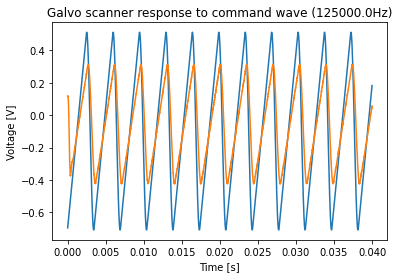

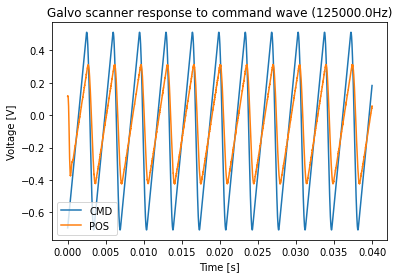

In [147]:
# 1.25e5 Hz

plot_cmd_pos(1.25e5, t3, cmd3, pos3)
plot_line(t3, cmd3, freq=1.25e5, ylabel1="CMD", ylabel2="POS", y2=pos3)

In [334]:
t4, cmd4, pos4 = write_voltage_waveform(2e5, xFrame_waveform)

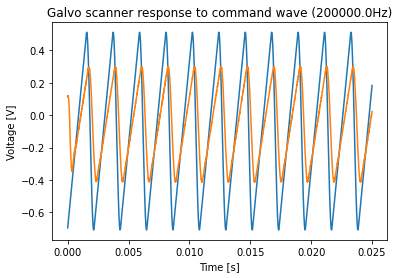

In [335]:
plot_cmd_pos(2e5, t4, cmd4, pos4)

In [326]:
t5, cmd5, pos5 = write_voltage_waveform(2.5e5, xFrame_waveform)

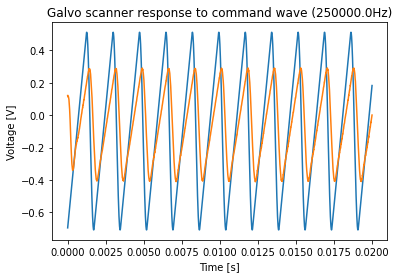

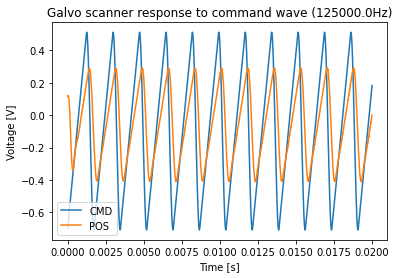

In [327]:
plot_cmd_pos(2.5e5, t5, cmd5, pos5)
plot_line(t5, cmd5, freq=1.25e5, ylabel1="CMD", ylabel2="POS", y2=pos5)

In [941]:
# plot_cmd_pos(1.25e5, t3[420:784], cmd3[420:784], pos3[420:784])

In [315]:
# every horizontal line in pos waveform has slightly different slopes

def calc_slope(f, t, cmd, pos, graph):
    # span of one linear scan
    start_idx = 420
    end_idx = 784
    
    cmd_slope_list = [] # list of slopes for each line in waveform
    pos_slope_list = [] # list of slopes for each line in waveform
    slope_ratio_list = [] # ratio between slopes
    
    for i in range(11): # checking every 434 (one whole x waveform) samples out of 5000 
        
        if start_idx <= len(cmd) and end_idx <= len(cmd):
            cmd_period = list(cmd[start_idx:end_idx])
            pos_period = list(pos[start_idx:end_idx])
            time_period = t[start_idx:end_idx]

            # get slope for one period
            cmd_max = np.nanmax(cmd_period)
            pos_max = np.nanmax(pos_period)
            cmd_min = np.nanmin(cmd_period)
            pos_min = np.nanmin(pos_period)

            cmd_max_t = cmd_period.index(float(cmd_max))
            pos_max_t = pos_period.index(float(pos_max))
            cmd_min_t = cmd_period.index(float(cmd_min))
            pos_min_t = pos_period.index(float(pos_min))

            cmd_slope = (cmd_max - cmd_min) / (time_period[cmd_max_t] - time_period[cmd_min_t])
            pos_slope = (pos_max - pos_min) / (time_period[pos_max_t] - time_period[pos_min_t])
            slope_ratio = cmd_slope / pos_slope
                        
            cmd_slope_list.append(cmd_slope)
            pos_slope_list.append(pos_slope)
            slope_ratio_list.append(slope_ratio)
            
            start_idx = 434 + start_idx
            end_idx = 434 + end_idx
            
        else:
            break 
    return cmd_slope_list, pos_slope_list, slope_ratio_list, np.average(slope_ratio_list)

def calc_time_delay_slope(f, t, cmd, pos, graph):
    # span of one linear scan
    start_idx = 420
    end_idx = 784
    
    cmd_slope_list = [] # list of slopes for each line in waveform
    pos_slope_list = [] # list of slopes for each line in waveform
    slope_ratio_list = [] # ratio between slopes
    time_delay_list = [] # each entry is a list of line delays at every sample for each line
    time_ave_delay_list = [] # average of line delays for each line
    time_range_delay_list = [] # ranges of line delays for each line
    cmd_period_list = [] # cmd values for each line
    adj_pos_period_list = [] # pos values for each line
    
    for i in range(11): # checking every 434 (one whole x waveform) samples out of 5000 
        
        if start_idx <= len(cmd) and end_idx <= len(cmd):
            cmd_period = list(cmd[start_idx:end_idx])
            pos_period = list(pos[start_idx:end_idx])
            time_period = t[start_idx:end_idx]

            # get slope for one period
            cmd_max = np.nanmax(cmd_period)
            pos_max = np.nanmax(pos_period)
            cmd_min = np.nanmin(cmd_period)
            pos_min = np.nanmin(pos_period)

            cmd_max_t = cmd_period.index(float(cmd_max))
            pos_max_t = pos_period.index(float(pos_max))
            cmd_min_t = cmd_period.index(float(cmd_min))
            pos_min_t = pos_period.index(float(pos_min))

            cmd_slope = (cmd_max - cmd_min) / (time_period[cmd_max_t] - time_period[cmd_min_t])
            pos_slope = (pos_max - pos_min) / (time_period[pos_max_t] - time_period[pos_min_t])
            slope_ratio = cmd_slope / pos_slope
            
            # adjust line to according slope
            adj_pos_waveform = []
            for j in pos_period:
                adj_pos_waveform.append(j * slope_ratio)
            
            time_delay = []
            for idx in range(len(adj_pos_waveform)):
                voltage = cmd_period[idx]
                for k in range(100): # look forward to around one full period
                    if k + idx >= len(adj_pos_waveform):
                        break
                    if adj_pos_waveform[k + idx - 1] < voltage and adj_pos_waveform[k + idx] >= voltage:
                        time_delay.append( t[k + idx] - t[idx])
                        break
                    elif adj_pos_waveform[k + idx - 1] > voltage and adj_pos_waveform[k + idx] <= voltage:
                        time_delay.append( t[k + idx] - t[idx])
                        break
                        
            cmd_slope_list.append(cmd_slope)
            pos_slope_list.append(pos_slope)
            slope_ratio_list.append(slope_ratio)
            time_delay_list.append(time_delay)
            time_ave_delay_list.append(np.average(time_delay))
            time_range_delay_list.append(np.max(time_delay) - np.min(time_delay))
            cmd_period_list.append(cmd_period)
            adj_pos_period_list.append(adj_pos_waveform)
            
            start_idx = 434 + start_idx
            end_idx = 434 + end_idx
            
        else:
            break 
    return cmd_slope_list, pos_slope_list, slope_ratio_list, np.average(slope_ratio_list), time_delay_list, time_ave_delay_list, time_range_delay_list, cmd_period_list, adj_pos_period_list


In [317]:
cs, ps, sr, sr_ave, td, tdave, tdr, cmdp, app = calc_time_delay_slope(5e4, t2, cmd2, pos2, "y")
# plot_xy("slope vs. average time delay (5e4 rate)", "slope", "time delay", ps1, tdave)
# plot_xy("slope vs. time delay range (5e4 rate)", "slope", "time delay", ps1, tdr)
# plot_galvo("time delay for first waveform (5e4 rate)", "time", "time delay", td[0])
# plot_cmd_pos(5e4, t[420:784], cmdp[0], app[0])
print(sr_ave)

1.615099136507644


1.6385596431677478


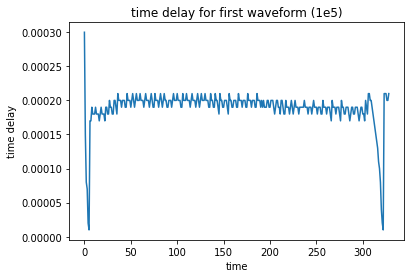

In [318]:
cs2, ps2, sr2, sr_ave2, td2, tdave2, tdr2, cmdp2, app2 = calc_time_delay_slope(1e5, t, cmd, pos, "y")
# plot_xy("slope vs. average time delay (1e5)", "slope", "time delay", ps2, tdave2)
# plot_xy("slope vs. time delay range (1e5)", "slope", "time delay", ps2, tdr2)
plot_galvo("time delay for first waveform (1e5)", "time", "time delay", td2[0])
# plot_cmd_pos(1e5, t[420:784], cmdp2[0], app2[0])
print(sr_ave2)

1.6488402245930271


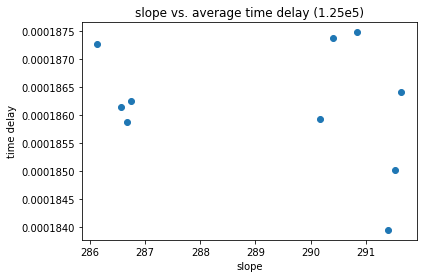

In [319]:
cs3, ps3, sr3, sr_ave3, td3, tdave3, tdr3, cmdp3, app3 = calc_time_delay_slope(1.25e5, t3, cmd3, pos3, "y")
plot_xy("slope vs. average time delay (1.25e5)", "slope", "time delay", ps3, tdave3)
# plot_xy("slope vs. time delay range", "slope", "time delay", ps3, tdr3)
# plot_galvo("time delay for first waveform", "time", "time delay", td3[0])
# plot_cmd_pos(1e5, t[420:784], cmdp3[0], app3[0])
print(sr_ave3)

1.6806588003952843


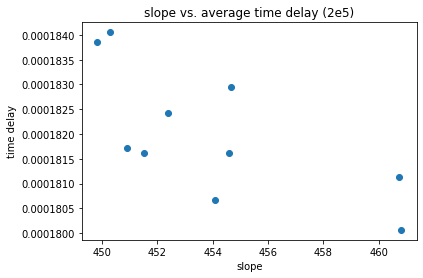

In [328]:
cs4, ps4, sr4, sr_ave4, td4, tdave4, tdr4, cmdp4, app4 = calc_time_delay_slope(2e5, t4, cmd4, pos4, "y")
plot_xy("slope vs. average time delay (2e5)", "slope", "time delay", ps4, tdave4)
# plot_xy("slope vs. time delay range", "slope", "time delay", ps3, tdr3)
# plot_galvo("time delay for first waveform", "time", "time delay", td4[0])
# plot_cmd_pos(1e5, t[420:784], cmdp3[0], app3[0])
print(sr_ave4)

1.669316823086793


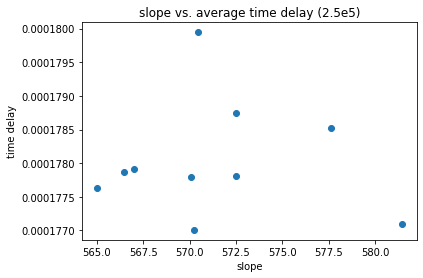

In [331]:
cs5, ps5, sr5, sr_ave5, td5, tdave5, tdr5, cmdp5, app5 = calc_time_delay_slope(2.5e5, t5, cmd5, pos5, "y")
plot_xy("slope vs. average time delay (2.5e5)", "slope", "time delay", ps5, tdave5)
# plot_xy("slope vs. time delay range", "slope", "time delay", ps3, tdr3)
# plot_galvo("time delay for first waveform", "time", "time delay", td5[0])
# plot_cmd_pos(1e5, t[420:784], cmdp3[0], app3[0])
print(sr_ave5)

4.350054392770111e-07
1.5941325552517809


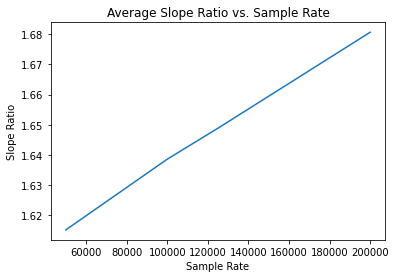

In [339]:
# slope_list = [sr_ave, sr_ave2, sr_ave3, sr_ave4, sr_ave5]
# samp_rate_list = [5e4, 1e5, 1.25e5, 2e5, 2.5e5]
slope_list = [sr_ave, sr_ave2, sr_ave3, sr_ave4]
samp_rate_list = [5e4, 1e5, 1.25e5, 2e5]
plot_line(samp_rate_list, slope_list, freq=None, title="Average Slope Ratio vs. Sample Rate", xlabel="Sample Rate", ylabel="Slope Ratio")
slope, intercept, r_value, p_value, std_err = stats.linregress(samp_rate_list, slope_list)
print(slope)
print(intercept)

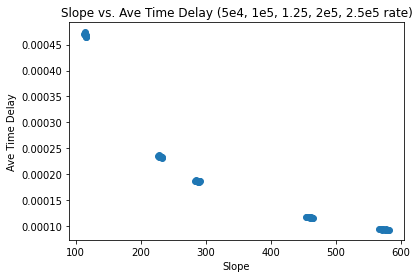

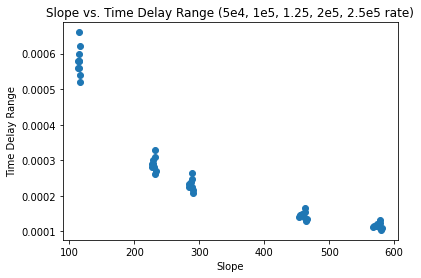

In [960]:
combined_time_delay_ave = tdave + tdave2 + tdave3 + tdave4 + tdave5
combined_pos_slope = ps + ps2 + ps3 + ps4 + ps5
combined_time_delay_range = tdr + tdr2 + tdr3 + tdr4 + tdr5
plot_xy("Slope vs. Ave Time Delay (5e4, 1e5, 1.25, 2e5, 2.5e5 rate)", "Slope", "Ave Time Delay", combined_pos_slope, combined_time_delay_ave)
plot_xy("Slope vs. Time Delay Range (5e4, 1e5, 1.25, 2e5, 2.5e5 rate)", "Slope", "Time Delay Range", combined_pos_slope, combined_time_delay_range)

In [1002]:
# Calculating time delay b/w cmd and pos using adjusted pos slope - using correlation

def calc_time_delay_corr(f, t, cmd, pos, graph):
    cs, ps, sr, ave_slope_ratio = calc_slope(f, t, cmd, pos, "n")
    print(ave_slope_ratio)
    adj_pos_waveform = []
    for i in pos:
        adj_pos_waveform.append(i * ave_slope_ratio)
    
    xcorr = np.correlate(pos, cmd, "full")
    dt = np.linspace(-t[-1], t[-1], (2 * len(t)) - 1)
    t_shift = dt[xcorr.argmax()]
    
    if graph == "y":
        print("Sample Rate: " + str(f))
        print("Time Delay (ms): " + str(t_shift * 1000) + "\n")
        plot_cmd_pos(f, t, cmd, adj_pos_waveform)
    # print(t_shift)
    return t_shift, adj_pos_waveform

In [842]:
# t_shift, adj_pos_waveform = calc_time_delay_corr(5e4, t2, cmd, pos2, "y")
# plot_cmd_pos(5e4, t2[100:2000], cmd2[100:2000], adj_pos_waveform[100:2000])

In [843]:
# t_shift, adj_pos_waveform = calc_time_delay_corr(1e5, t, cmd, pos, "y")
# plot_cmd_pos(1e5, t[100:2000], cmd2[100:2000], adj_pos_waveform[100:2000])

In [759]:
# calc_time_delay(1.25e5, t3[100:], cmd3[100:], pos3[100:], "y")
# calc_time_delay(1.25e5, t3[100:2000], cmd3[100:2000], pos3[100:2000], "y")

In [1006]:
# Calculating time delay b/w cmd and pos using adjusted pos slope - using averaged slope difference

def calc_time_delay_ave_slope(f, t, cmd, pos):
    cs, ps, sr, ave_slope_ratio = calc_slope(f, t, cmd, pos, "n")
    adj_pos_waveform = []
    for i in pos:
        adj_pos_waveform.append(i * ave_slope_ratio)
        
    time_delay = []
    for idx in range(len(cmd)):
        voltage = cmd[idx]
        for j in range(100): # look forward to around one full period
            if j + idx >= len(t):
                break
            if adj_pos_waveform[idx - 1] < voltage and adj_pos_waveform[idx] > voltage:
                continue
            if adj_pos_waveform[j + idx - 1] < voltage and adj_pos_waveform[j + idx] >= voltage:
                time_delay.append( t[j + idx] - t[idx])
                break
            elif adj_pos_waveform[j + idx - 1] > voltage and adj_pos_waveform[j + idx] <= voltage:
                time_delay.append( t[j + idx] - t[idx])
                break
    
    new_time_delay = []
    for i in time_delay:
        new_time_delay.append(i * 1000)
    
    fig, ax = plt.subplots()
    ax.set_title("Galvo scanner response to command wave (" + str(f) + "Hz)")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Voltage [V]")
    ax.plot(t[:len(time_delay)], cmd[:len(time_delay)], label="cmd")
    ax.plot(t[:len(time_delay)], adj_pos_waveform[:len(time_delay)], label="pos")
    ax.plot(t[:len(time_delay)], new_time_delay, label="delay (upscaled)")
    ax.legend()
    
    fig, ax = plt.subplots()
    ax.set_title("Time vs. Corresponding Time Delay (" + str(f) + "Hz)")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Time Delay [s]")
    ax.plot(t[:len(time_delay)], time_delay)
    
    return t[:len(time_delay)], cmd[:len(time_delay)], adj_pos_waveform[:len(time_delay)], new_time_delay

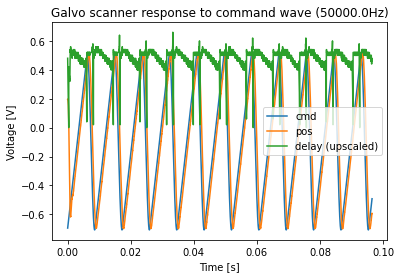

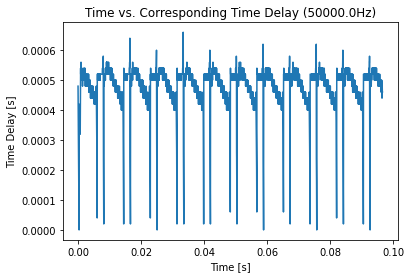

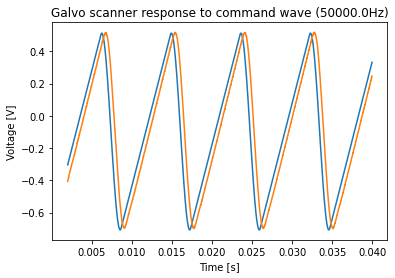

In [1007]:
new_t, new_cmd, new_adj, time_delay = calc_time_delay_ave_slope(5e4, t2, cmd2, pos2)
plot_cmd_pos(5e4, new_t[100:2000], new_cmd[100:2000], new_adj[100:2000])

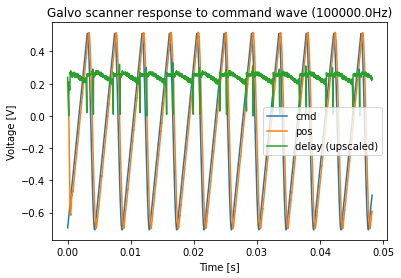

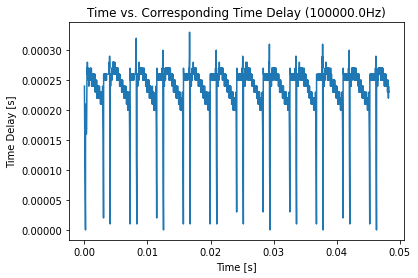

In [1008]:
new_t2, new_cmd2, new_adj2, time_delay2 = calc_time_delay_ave_slope(1e5, t, cmd, pos)

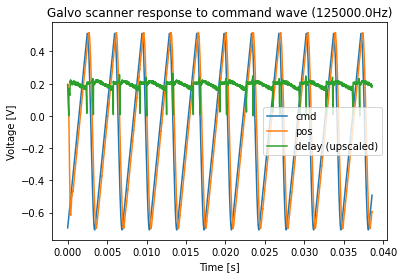

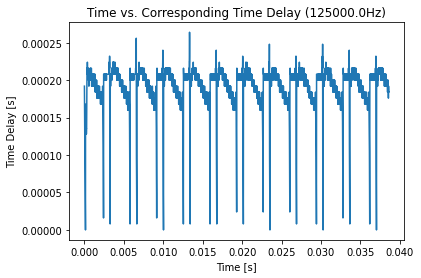

In [1011]:
new_t3, new_cmd3, new_adj3, time_delay3 = calc_time_delay_ave_slope(1.25e5, t3, cmd3, pos3)

In [1012]:
# Shifting adjusted pos waveform to see how closely matches with cmd waveform

def adj_for_delay(f, t, cmd, pos, graph):
    time_shift, adj_pos_waveform = calc_time_delay(f, t, cmd, pos, "n")
    time_idx = 0
    for i in range(len(t)):
        if t[i] >= time_shift:
            time_idx = i
            break
    new_pos_waveform = adj_pos_waveform[time_idx:]
    adj_cmd_waveform = cmd[:(len(cmd) - time_idx)]
    adj_time_waveform = t[:(len(cmd) - time_idx)]
    if graph == "y":
        plot_cmd_pos(f, adj_time_waveform, adj_cmd_waveform, new_pos_waveform)

In [963]:
# adj_for_delay(1e5, t, cmd, pos, "y")

In [964]:
# adj_for_delay(1e5, t[:2000], cmd[:2000], pos[:2000], "y")

In [965]:
# adj_for_delay(5e4, t2, cmd2, pos2, "y")

In [966]:
# adj_for_delay(5e4, t2[:2000], cmd2[:2000], pos2[:2000], "y")

In [967]:
# TODO:
# combination of different slopes and zoom factors
# get different slopes but same frequencies by adjusting both sample rate and zoom (amplitude)
# try: seeing y waveform, testing different frequencies using solely sine waveforms

# DONE:
# graph: different slope vs. delay (points - hopefully linear), single scan vs delay
# make different graphs for different zoom factors (and resolution?)


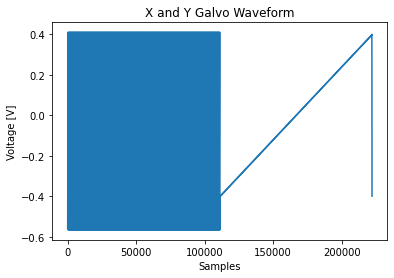

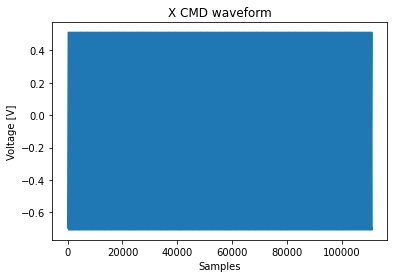

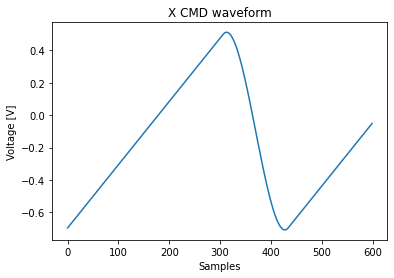

In [70]:
zoom = 1.25
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, zoom, undershoot, 0, 0, 0, 0)
plot_galvo("X and Y Galvo Waveform", "Samples", "Voltage [V]", frame)
xFrame_ = frame[:int(frameLength / 2)]
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame)
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame[:600])
xFrame_waveform_z1_25 = xFrame[:5000]

In [71]:
t_z1_25, cmd_z1_25, pos_z1_25 = write_voltage_waveform(1e5, xFrame_waveform_z1_25)

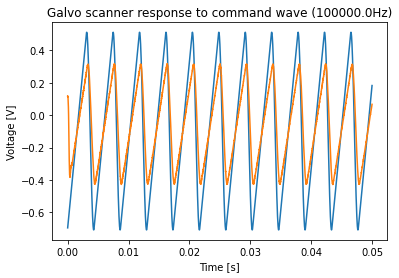

In [72]:
plot_cmd_pos(1e5, t_z1_25, cmd_z1_25, pos_z1_25)

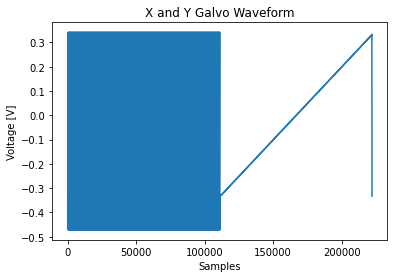

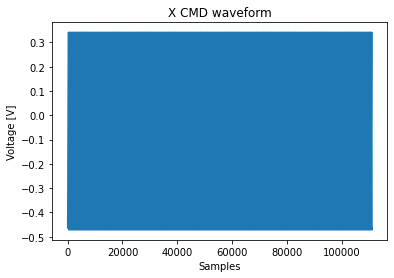

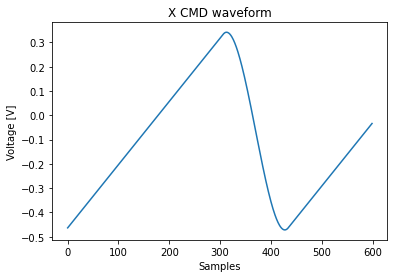

In [77]:
zoom = 1.5
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, zoom, undershoot, 0, 0, 0, 0)
plot_galvo("X and Y Galvo Waveform", "Samples", "Voltage [V]", frame)
xFrame = frame[:int(frameLength / 2)]
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame)
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame[:600])
xFrame_waveform_z1_5 = xFrame[:5000]

In [78]:
t_z1_5, cmd_z1_5, pos_z1_5 = write_voltage_waveform(1e5, xFrame_waveform_z1_5)

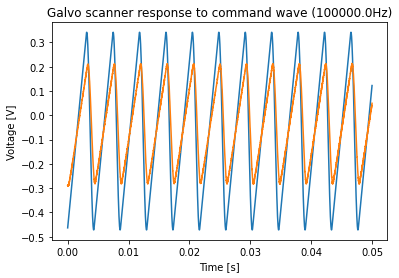

In [79]:
plot_cmd_pos(1e5, t_z1_5, cmd_z1_5, pos_z1_5)

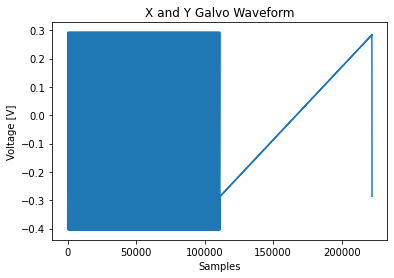

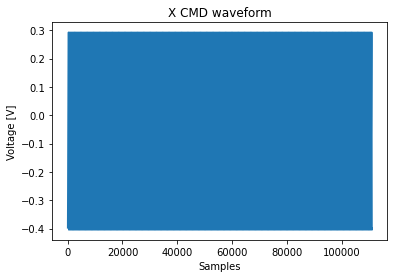

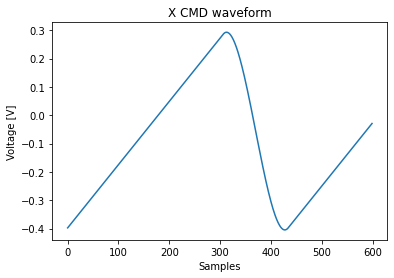

In [889]:
zoom = 1.75
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, zoom, undershoot, 0, 0, 0, 0)
plot_galvo("X and Y Galvo Waveform", "Samples", "Voltage [V]", frame)
xFrame = frame[:int(frameLength / 2)]
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame)
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame[:600])
xFrame_waveform_z1_75 = xFrame[:5000]

In [890]:
t_z1_75, cmd_z1_75, pos_z1_75 = write_voltage_waveform(1e5, xFrame_waveform_z1_75)

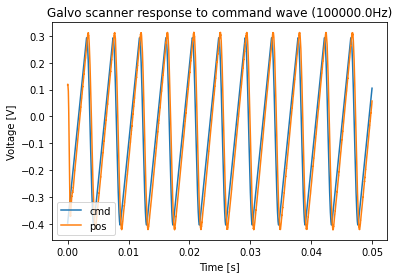

In [892]:
plot_cmd_pos(1e5, t_z1_75, cmd_z1_75, pos_z1_75)

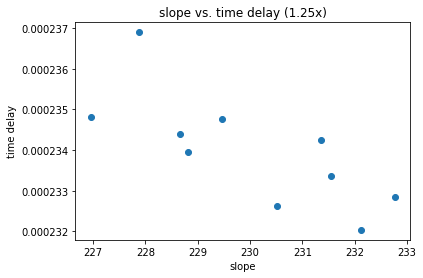

In [981]:
cs, ps1_25, sr, sr_ave, td, tdave1_25, tdr, cmdp, app = calc_time_delay_slope(1e5, t_z1_25, cmd_z1_25, pos_z1_25, "y")
plot_xy("slope vs. time delay (1.25x)", "slope", "time delay", ps1_25, tdave1_25)

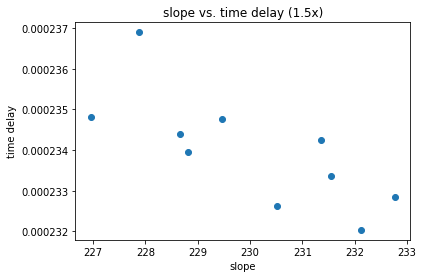

In [980]:
cs, ps1_5, sr, sr_ave, td, tdave1_5, tdr, cmdp, app = calc_time_delay_slope(1e5, t_z1_5, cmd_z1_5, pos_z1_5, "y")
plot_xy("slope vs. time delay (1.5x)", "slope", "time delay", ps1_5, tdave1_5)

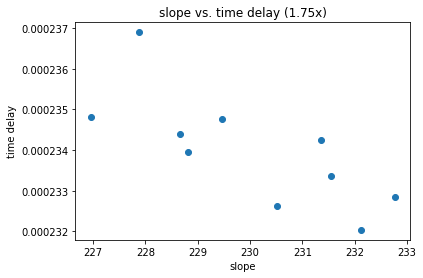

In [1009]:
cs, ps1_75, sr, sr_ave, td, tdave1_75, tdr, cmdp, app = calc_time_delay_slope(1e5, t_z1_75, cmd_z1_75, pos_z1_75, "y")
plot_xy("slope vs. time delay (1.75x)", "slope", "time delay", ps1_75, tdave1_75)
# plot_xy("slope vs. time delay range", "slope", "time delay", ps1, tdr)
# plot_galvo("time delay for first waveform", "time", "time delay", td[0])
# plot_cmd_pos(5e4, t[420:784], cmdp[0], app[0])

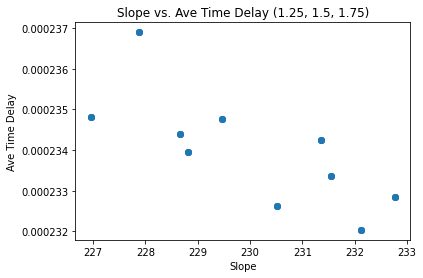

In [978]:
combined_time_delay_ave = tdave1_25 + tdave1_5 + tdave1_75
combined_pos_slope = ps1_25 + ps1_5 + ps1_75
# combined_time_delay_range = tdr + tdr2 + tdr3 + tdr4 + tdr5
plot_xy("Slope vs. Ave Time Delay (1.25, 1.5, 1.75)", "Slope", "Ave Time Delay", combined_pos_slope, combined_time_delay_ave)
# plot_xy("Slope vs. Time Delay Range (5e4, 1e5, 1.25, 2e5, 2.5e5 rate)", "Slope", "Time Delay Range", combined_pos_slope, combined_time_delay_range)

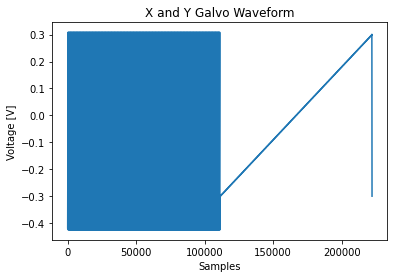

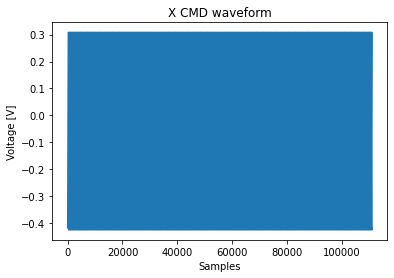

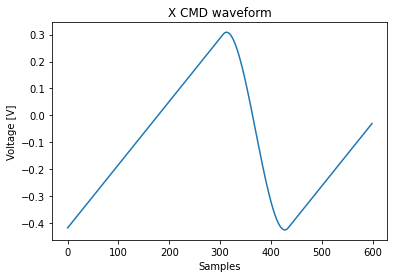

In [83]:
zoom = 1.66
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, zoom, undershoot, 0, 0, 0, 0)
plot_galvo("X and Y Galvo Waveform", "Samples", "Voltage [V]", frame)
xFrame = frame[:int(frameLength / 2)]
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame)
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame[:600])
xFrame_waveform_z1_66 = xFrame[:5000]

In [84]:
t_z1_66, cmd_z1_66, pos_z1_66 = write_voltage_waveform(1e5, xFrame_waveform_z1_66)

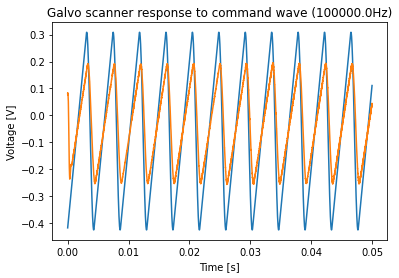

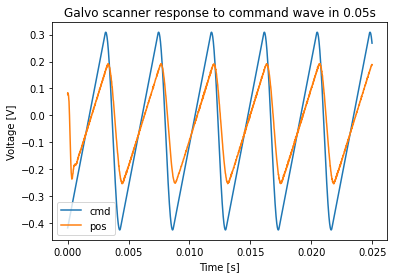

In [85]:
plot_cmd_pos(1e5, t_z1_66, cmd_z1_66, pos_z1_66)
plot_cmd_pos_zoom(t_z1_66, cmd_z1_66, pos_z1_66)

In [80]:
# new_t1_66, new_cmd1_66, new_adj1_66, time_delay1_66 = calc_time_delay_ave_slope(1e5, t_z1_66, cmd_z1_66, pos_z1_66)

In [101]:
# zoom = 1
# undershoot = 1
# frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, zoom, undershoot, 0, 0, 0, 0)
# plot_galvo("X and Y Galvo Waveform", "Samples", "Voltage [V]", frame)
# xFrame = frame[:int(frameLength / 2)]
# plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame)
# plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame[:600])
# xFrame_waveform_1 = xFrame[:5000]

In [99]:
# t, cmd, pos = write_voltage_waveform(1e5, xFrame_waveform_1)

In [100]:
# plot_cmd_pos(1e5, t, cmd, pos)

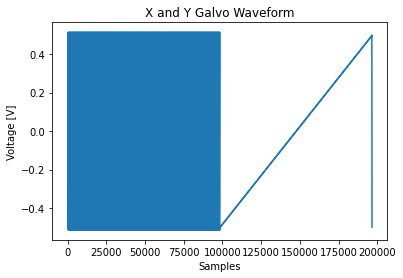

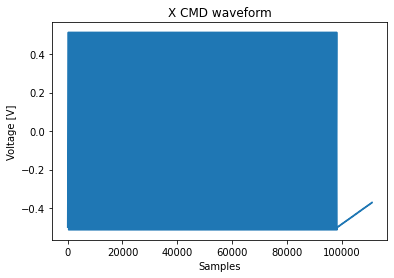

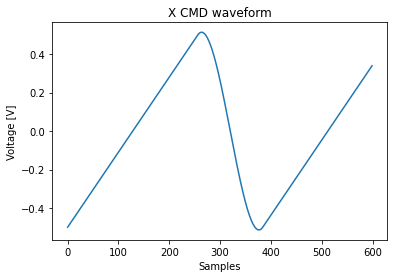

In [148]:
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, 1, 0, 0, 0, 0, 0)
plot_galvo("X and Y Galvo Waveform", "Samples", "Voltage [V]", frame)
xFrame = frame[:int(frameLength / 2)]
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame)
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame[:600])
xFrame_waveform_us_0 = xFrame[:5000]

In [92]:
t_us_0, cmd_us_0, pos_us_0 = write_voltage_waveform(1.25e6, xFrame_waveform_us_0)

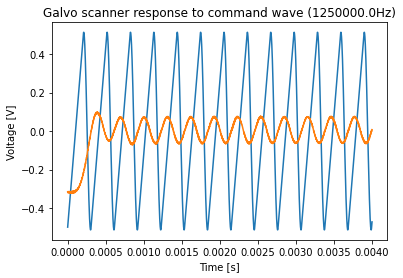

In [311]:
# At max sampling rate

plot_cmd_pos(1.25e6, t_us_0, cmd_us_0, pos_us_0)

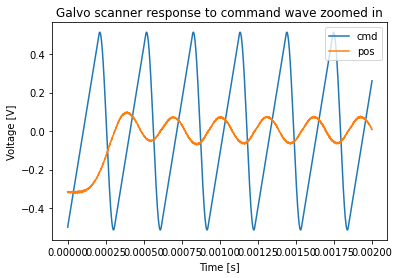

In [312]:
plot_cmd_pos_zoom(t_us_0, cmd_us_0, pos_us_0)

In [210]:
# plot_xy_line("Galvo Response", "Time [s]", "Voltage [V]", t_us_0[400:500], cmd_us_0[400:500])

In [149]:
t2_5e5_us0, cmd2_5e5_us0, pos2_5e5_us0 = write_voltage_waveform(2.5e5, xFrame_waveform_us_0)

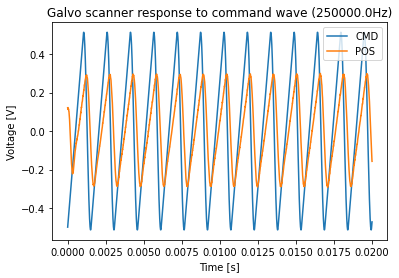

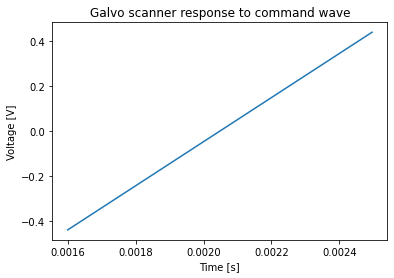

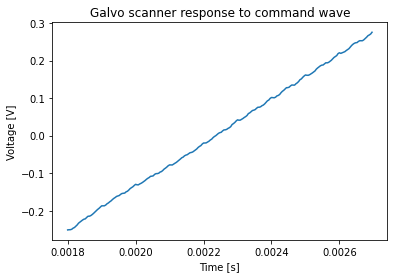

In [209]:
plot_line(t2_5e5_us0, cmd2_5e5_us0, freq=2.5e5, ylabel1="CMD", ylabel2="POS", y2=pos2_5e5_us0)
plot_line(t2_5e5_us0[400:625], cmd2_5e5_us0[400:625])
plot_line(t2_5e5_us0[450:675], pos2_5e5_us0[450:675])

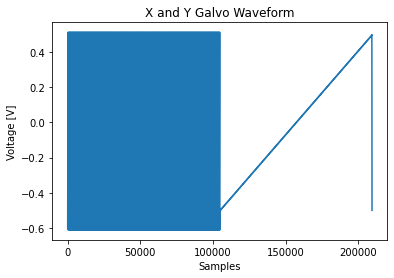

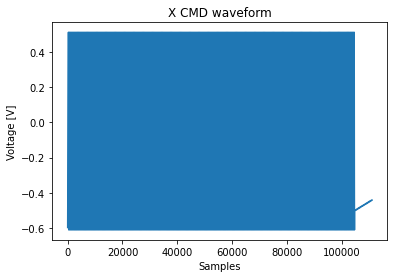

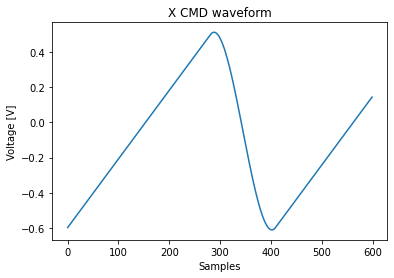

In [241]:
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, 1, 25, 0, 0, 0, 0)
plot_galvo("X and Y Galvo Waveform", "Samples", "Voltage [V]", frame)
xFrame = frame[:int(frameLength / 2)]
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame)
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame[:600])
xFrame_waveform_us_25 = xFrame[:5000]

In [242]:
t2_5e5_us25, cmd2_5e5_us25, pos2_5e5_us25 = write_voltage_waveform(2.5e5, xFrame_waveform_us_25)

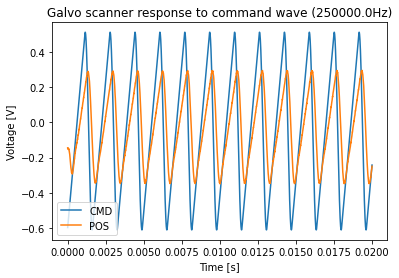

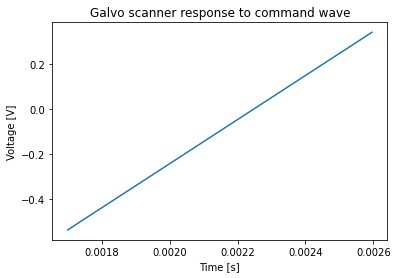

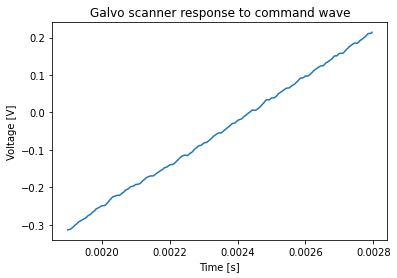

In [243]:
plot_line(t2_5e5_us25, cmd2_5e5_us25, freq=2.5e5, ylabel1="CMD", ylabel2="POS", y2=pos2_5e5_us25)
plot_line(t2_5e5_us25[425:650], cmd2_5e5_us25[425:650])
plot_line(t2_5e5_us25[475:700], pos2_5e5_us25[475:700])

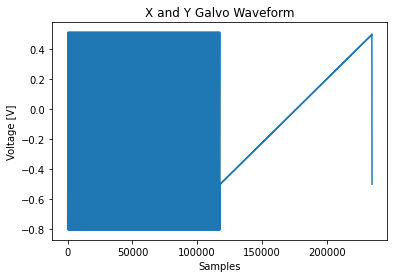

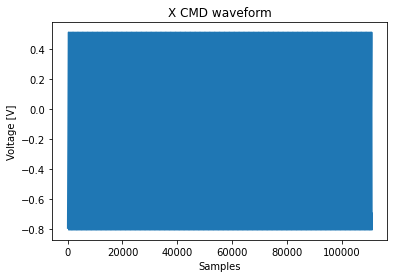

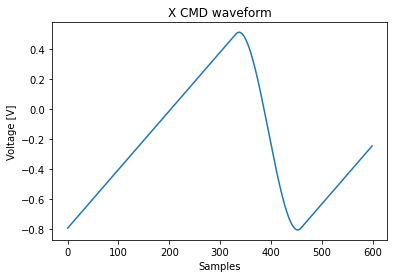

In [267]:
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, 1, 75, 0, 0, 0, 0)
plot_galvo("X and Y Galvo Waveform", "Samples", "Voltage [V]", frame)
xFrame = frame[:int(frameLength / 2)]
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame)
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame[:600])
xFrame_waveform_us_75 = xFrame[:5000]

In [268]:
t2_5e5_us75, cmd2_5e5_us75, pos2_5e5_us75 = write_voltage_waveform(2.5e5, xFrame_waveform_us_75)

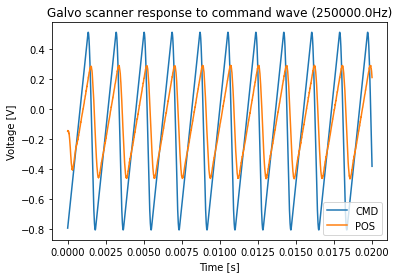

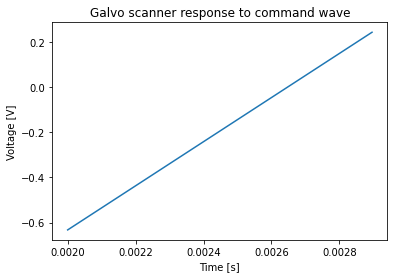

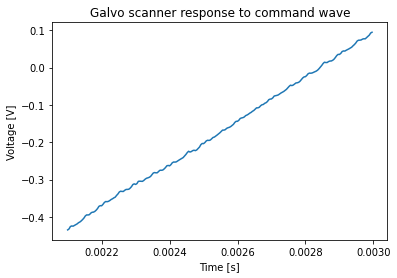

In [272]:
plot_line(t2_5e5_us75, cmd2_5e5_us75, freq=2.5e5, ylabel1="CMD", ylabel2="POS", y2=pos2_5e5_us75)
plot_line(t2_5e5_us75[500:725], cmd2_5e5_us75[500:725])
plot_line(t2_5e5_us75[525:750], pos2_5e5_us75[525:750])

In [297]:
def new_line_regression(x_data, y_data, start, end, new_start=None, new_end=None, title="Galvo Response"):
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data[start:end], y_data[start:end])
    if new_start == None and new_end == None: # if length is the same
        new_start = start
        new_end = end
    
    old_y_data_section = y_data[start:end]
    new_y_data_section = y_data[new_start:new_end]
    
    # generated linear fit (same length)
    same_linear_fit = []
    for i in x_data[start:end]:
        val = intercept + slope * i
        same_linear_fit.append(val)

    # calculate voltage differences b/w actual and linear fit (same length)
    same_y_diff_list = []
    for i in range(len(same_linear_fit)):
        y_diff = abs(old_y_data_section[i] - same_linear_fit[i])
        same_y_diff_list.append(y_diff)

    # average and max of those differences (of same length)
    y_ave = np.average(same_y_diff_list)
    y_max = np.max(same_y_diff_list)
    
    # generate linear fit (longer length)
    new_linear_fit = []
    for i in x_data[new_start:new_end]:
        val = intercept + slope * i
        new_linear_fit.append(val)
    
    # calculate voltage differences b/w actual and linear fit (longer length)
    new_y_diff_list = []
    for i in range(len(new_linear_fit)):
        new_y_diff = abs(new_y_data_section[i] - new_linear_fit[i])
        new_y_diff_list.append(new_y_diff)
                                
    # finding start and stop voltages
    # upper half of data
    max_idx = 0
    for i in range(int(len(new_y_diff_list)/2)):
        idx = int(len(new_y_diff_list)/2) + i
        if idx > len(x_data): # if index goes over
            break
        else: 
            y_diff = abs(new_y_diff_list[idx])
            if y_diff > y_max: 
                max_idx = idx
                break
    y_stop = new_y_data_section[max_idx]
    
    # lower half of data
    min_idx = 0
    for i in range(int(len(new_y_diff_list)/2)):
        idx = int(len(new_y_diff_list)/2) - i
        y_diff = abs(new_y_diff_list[idx])
        if y_diff > y_max:
            min_idx = idx
            break
    y_start = new_y_data_section[min_idx]
    
    new_x = x_data[new_start:new_end]
    new_y = y_data[new_start:new_end]
    
    print(title + "\nStart Voltage: " + str(y_start) + "\nStop Voltage: " + str(y_stop))    
    plot_line(new_x, new_y, title=title, ylabel1="Actual", ylabel2="Linear Fit", ylabel3="Voltage Difference From Linear Fit", y2=new_linear_fit, y3=new_y_diff_list, markers=[min_idx,max_idx])
        
    return x_data[new_start:new_end], y_data[new_start:new_end], new_linear_fit, y_start, y_stop

Start and Stop on CMD (2.5e5) Undershoot = 0
Start Voltage: -0.5036330223083496
Stop Voltage: 0.5036330223083496
Start and Stop on POS (2.5e5) Undershoot = 0
Start Voltage: -0.2766518289337844
Stop Voltage: 0.2917018926220376


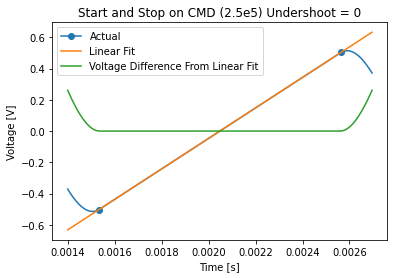

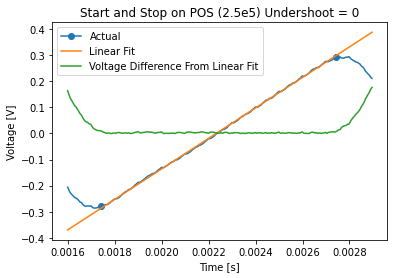

In [298]:
x1, old_y, new_y, ystart1, yend1 = new_line_regression(t2_5e5_us0, cmd2_5e5_us0, 400, 625, new_start=350, new_end=675, title="Start and Stop on CMD (2.5e5) Undershoot = 0")
x2, old_y2, new_y2, ystart2, yend2 = new_line_regression(t2_5e5_us0, pos2_5e5_us0, 450, 675, new_start=400, new_end=725, title="Start and Stop on POS (2.5e5) Undershoot = 0")

Start and Stop on CMD (2.5e5) Undershoot = 25
Start Voltage: -0.6012714840471745
Stop Voltage: 0.5036152340471745
Start and Stop on POS (2.5e5) Undershoot = 25
Start Voltage: -0.3365031923993719
Stop Voltage: 0.2881076832544311


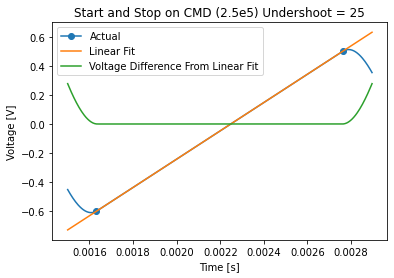

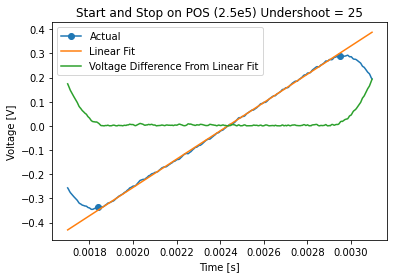

In [299]:
x5, old_y5, new_y5, ystart5, yend5 = new_line_regression(t2_5e5_us25, cmd2_5e5_us25, 425, 675, new_start=375, new_end=725, title="Start and Stop on CMD (2.5e5) Undershoot = 25")
x6, old_y6, new_y6, ystart6, yend6 = new_line_regression(t2_5e5_us25, pos2_5e5_us25, 475, 725, new_start=425, new_end=775, title="Start and Stop on POS (2.5e5) Undershoot = 25")

Start and Stop on CMD (2.5e5) Undershoot = 50
Start Voltage: -0.6989099457859993
Stop Voltage: 0.5035974457859993
Start and Stop on POS (2.5e5) Undershoot = 50
Start Voltage: -0.3951043937623007
Stop Voltage: 0.28138807447551456


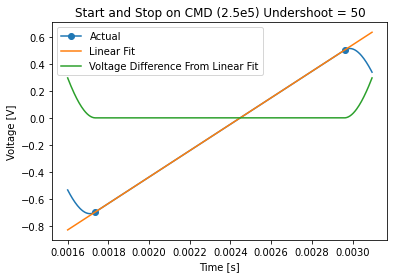

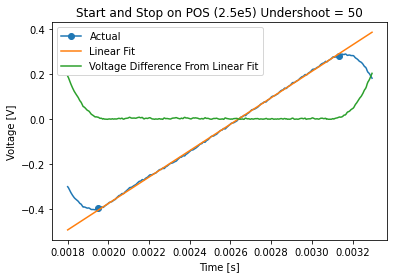

In [300]:
x3, old_y3, new_y3, ystart3, yend3 = new_line_regression(t5, cmd5, 450, 725, new_start=400, new_end=775, title="Start and Stop on CMD (2.5e5) Undershoot = 50")
x4, old_y4, new_y4, ystart4, yend4 = new_line_regression(t5, pos5, 500, 775, new_start=450, new_end=825, title="Start and Stop on POS (2.5e5) Undershoot = 50")

Start and Stop on CMD (2.5e5) Undershoot = 75
Start Voltage: -0.7965484075248241
Stop Voltage: 0.5035796575248241
Start and Stop on POS (2.5e5) Undershoot = 75
Start Voltage: -0.45542456060119213
Stop Voltage: 0.2843572039297397


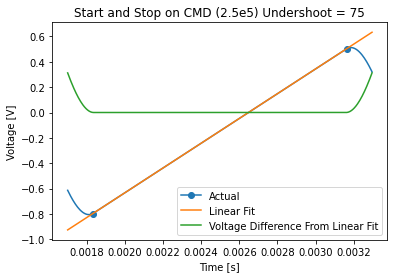

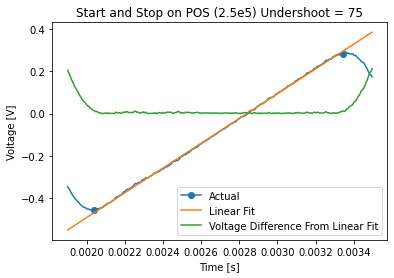

In [295]:
x7, old_y7, new_y7, ystart7, yend7 = new_line_regression(t2_5e5_us75, cmd2_5e5_us75, 475, 775, new_start=425, new_end=825, title="Start and Stop on CMD (2.5e5) Undershoot = 75")
x8, old_y8, new_y8, ystart8, yend8 = new_line_regression(t2_5e5_us75, pos2_5e5_us75, 525, 800, new_start=475, new_end=875, title="Start and Stop on POS (2.5e5) Undershoot = 75")

In [308]:
# cmd_diff_0_25 = ystart1 - ystart5
# cmd_diff_25_50 = ystart5 - ystart3
# cmd_diff_50_75 = ystart3 - ystart7

# pos_diff_0_25 = ystart2 - ystart6
# pos_diff_25_50 = ystart6 - ystart4
# pos_diff_50_75 = ystart4 - ystart8

# print("START Voltage: ")
# print("CMD Difference b/w 0 and 25 undershoot: " + str(cmd_diff_0_25))
# print("CMD Difference b/w 25 and 50 undershoot: " + str(cmd_diff_25_50))
# print("CMD Difference b/w 50 and 75 undershoot: " + str(cmd_diff_50_75) + "\n")

# print("POS Difference b/w 0 and 25 undershoot: " + str(pos_diff_0_25))
# print("POS Difference b/w 25 and 50 undershoot: " + str(pos_diff_25_50))
# print("POS Difference b/w 50 and 75 undershoot: " + str(pos_diff_50_75))

cmd_diff_0 = ystart1 - ystart2
cmd_diff_25 = ystart5 - ystart6
cmd_diff_50 = ystart3 - ystart4
cmd_diff_75 = ystart7 - ystart8

print("START Voltage: ")
print("CMD/POS Difference for 0 undershoot: " + str(cmd_diff_0))
print("CMD/POS Difference for 25 undershoot: " + str(cmd_diff_25))
print("CMD/POS Difference for 50 undershoot: " + str(cmd_diff_50))
print("CMD/POS Difference for 75 undershoot: " + str(cmd_diff_75))

cmd_diff_0 = yend1 - yend2
cmd_diff_25 = yend5 - yend6
cmd_diff_50 = yend3 - yend4
cmd_diff_75 = yend7 - yend8

print("\nEND Voltage: ")
print("CMD/POS Difference for 0 undershoot: " + str(cmd_diff_0))
print("CMD/POS Difference for 25 undershoot: " + str(cmd_diff_25))
print("CMD/POS Difference for 50 undershoot: " + str(cmd_diff_50))
print("CMD/POS Difference for 75 undershoot: " + str(cmd_diff_75))

START Voltage: 
CMD/POS Difference for 0 undershoot: -0.22698119337456518
CMD/POS Difference for 25 undershoot: -0.2647682916478026
CMD/POS Difference for 50 undershoot: -0.3038055520236986
CMD/POS Difference for 75 undershoot: -0.341123846923632

END Voltage: 
CMD/POS Difference for 0 undershoot: 0.211931129686312
CMD/POS Difference for 25 undershoot: 0.21550755079274336
CMD/POS Difference for 50 undershoot: 0.22220937131048474
CMD/POS Difference for 75 undershoot: 0.21922245359508447


In [307]:
# cmd_diff_0_25 = yend1 - yend5
# cmd_diff_25_50 = yend5 - yend3
# cmd_diff_50_75 = yend3 - yend7

# pos_diff_0_25 = yend2 - yend6
# pos_diff_25_50 = yend6 - yend4
# pos_diff_50_75 = yend4 - yend8

# print("END Voltage: ")
# print("CMD Difference b/w 0 and 25 undershoot: " + str(cmd_diff_0_25))
# print("CMD Difference b/w 25 and 50 undershoot: " + str(cmd_diff_25_50))
# print("CMD Difference b/w 50 and 75 undershoot: " + str(cmd_diff_50_75) + "\n")

# print("POS Difference b/w 0 and 25 undershoot: " + str(pos_diff_0_25))
# print("POS Difference b/w 25 and 50 undershoot: " + str(pos_diff_25_50))
# print("POS Difference b/w 50 and 75 undershoot: " + str(pos_diff_50_75))

In [313]:
def SplineInterpolate(n, yFirst, yLast, slopeFirst, slopeLast):
    m = float(n)
    mm = float(m * m)
    mmm = float(m * m *m)
    c = []
    c.append(slopeFirst / mm + 2.0 * yFirst / mmm + slopeLast / mm - 2.0 * yLast / mmm)
    c.append(3.0 * yLast / mm - slopeLast / m - 2.0 * slopeFirst / m - 3.0 * yFirst / mm)
    c.append(slopeFirst)
    c.append(yFirst)
    
    result = []
    n = int(n)
    for i in range(n):
        result.append(c[0] * i*i*i + c[1] * i*i + c[2] * i + c[3])
    return result

def GenerateXWaveform(scanLen, retraceLen, undershootLen, scanStart, scanEnd):
    waveform = []
    scanAmp = scanEnd - scanStart
    step = scanAmp/scanLen
    linearLen = undershootLen + scanLen
    undershootStart = scanStart - undershootLen * step
    
    for i in range(linearLen):
        val = undershootStart + step * i
        waveform.append(val)
    if retraceLen > 0:
        splineWaveform = SplineInterpolate(retraceLen, scanEnd, undershootStart, step, step)
        completeWaveform = waveform + splineWaveform
    return completeWaveform

In [638]:
def scan_waveform(start_voltage, end_voltage, time_frame, sample_rate):
    # initial prameters (const)
    # end voltage 1 for now
    time_frame = .002 # in seconds
    time_undershoot = .0005
    rv_slope = -2 * 1000/ (sample_rate)  #2-5 V/ms converted to V/samples - EDIT
    
    slope_ratio = 4.35e-7 * sample_rate + 1.59413 
    
    # waveform parameters
    fw_samps = int(time_frame * sample_rate)
    fw_slope = ( (end_voltage - start_voltage) * slope_ratio ) / fw_samps
    # print(fw_samps)

    # calculate
    # line_delay
    # maybe overshoot if applicable
    
    
    # Generating Scanner Waveform
    scan_line = []
    retrace = []
    
    us_samps = sample_rate * time_undershoot
    # scan_start = -1 * (fw_slope * us_samps - start_voltage) # edit
    scan_start = 0
    us_start = scan_start - us_samps * fw_slope
    rv_length = int(-1 * (end_voltage - start_voltage) * slope_ratio / rv_slope)
    
    print(fw_samps)
    for i in range(fw_samps):
        val = fw_slope * i + us_start
        scan_line.append(val)
    
    # add overshoot at end of scan line if applicable
    for j in range(rv_length):
        retrace.append(j * rv_slope + val)
    
    complete_waveform = scan_line + retrace
    num_samples = fw_samps + rv_length
    samples = []
    for k in range(num_samples):
        samples.append(k)

    return complete_waveform, samples

def x_waveform(waveform, samples, resolution):
    complete_waveform = []
    for i in range(resolution):
        for j in samples:
            complete_waveform.append(waveform[j])
    return complete_waveform

In [644]:
galvo_waveform_5e4, num_samples_5e4 = scan_waveform(0, 1, .002, sample_rate=5e4)
galvo_waveform_2e5_05, num_samples_2e5_05 = scan_waveform(0, 0.5, .002, sample_rate=2e5)
galvo_waveform_2_5e5, num_samples_2_5e5 = scan_waveform(0, 1, .002, sample_rate=2.5e5)
galvo_waveform_2_5e5_05, num_samples_2_5e5_05 = scan_waveform(0, 0.5, .002, sample_rate=2.5e5)
galvo_waveform_1_25e6, num_samples_1_25e6 = scan_waveform(0, 1, .002, sample_rate=1.25e6)
# galvo_waveform2, num_samples2 = scan_waveform(0, 2, .002, sample_rate=1.25e6)

100
400
500
500
2500


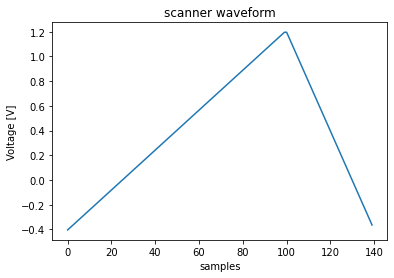

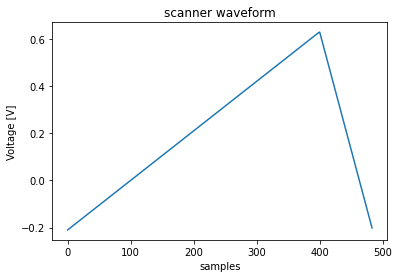

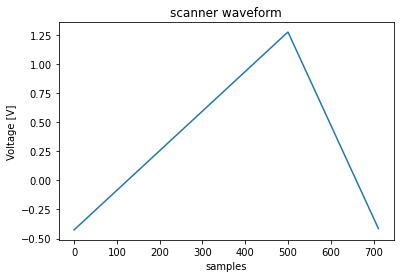

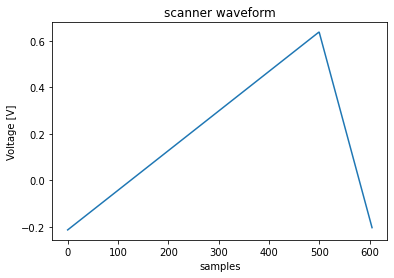

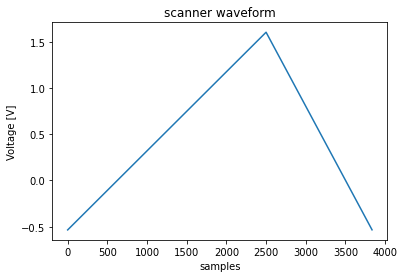

In [645]:
# plot_galvo("scanner waveform", "samples", "voltage", galvo_waveform)
plot_line(num_samples_5e4, galvo_waveform_5e4, title="scanner waveform", xlabel="samples")
plot_line(num_samples_2e5_05, galvo_waveform_2e5_05, title="scanner waveform", xlabel="samples")
plot_line(num_samples_2_5e5, galvo_waveform_2_5e5, title="scanner waveform", xlabel="samples")
plot_line(num_samples_2_5e5_05, galvo_waveform_2_5e5_05, title="scanner waveform", xlabel="samples")
plot_line(num_samples_1_25e6, galvo_waveform_1_25e6, title="scanner waveform", xlabel="samples")

In [646]:
waveform_5e4 = x_waveform(galvo_waveform_5e4, num_samples_5e4, 256)
waveform_2e5_05 = x_waveform(galvo_waveform_2e5_05, num_samples_2e5_05, 256)
waveform_2_5e5 = x_waveform(galvo_waveform_2_5e5, num_samples_2_5e5, 256)
waveform_2_5e5_05 = x_waveform(galvo_waveform_2_5e5_05, num_samples_2_5e5_05, 256)
waveform_1_25e6 = x_waveform(galvo_waveform_1_25e6, num_samples_1_25e6, 256)

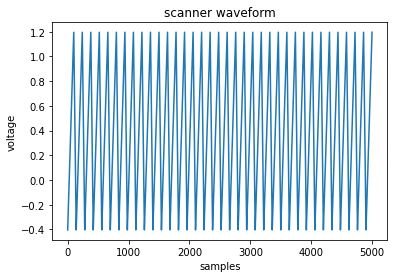

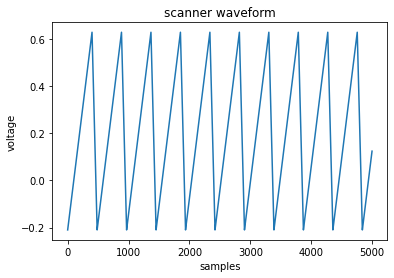

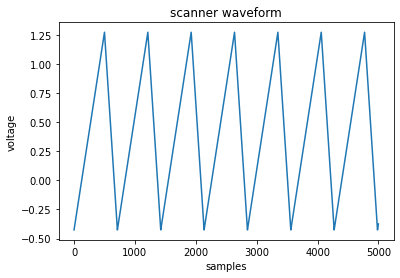

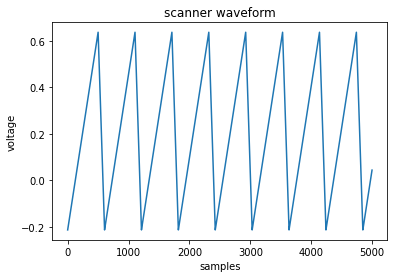

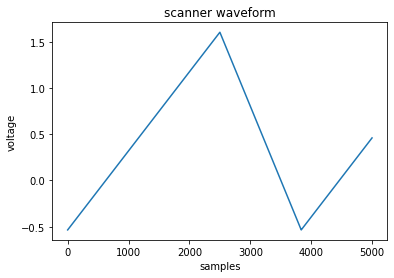

In [647]:
plot_galvo("scanner waveform", "samples", "voltage", waveform_5e4[:5000])
plot_galvo("scanner waveform", "samples", "voltage", waveform_2e5_05[:5000])
plot_galvo("scanner waveform", "samples", "voltage", waveform_2_5e5[:5000])
plot_galvo("scanner waveform", "samples", "voltage", waveform_2_5e5_05[:5000])
plot_galvo("scanner waveform", "samples", "voltage", waveform_1_25e6[:5000])

In [621]:
xframe_waveform = waveform_2_5e5[:5000]

In [632]:
xframe_waveform_05 = waveform_2_5e5_05[:5000]

In [648]:
xframe_waveform_2e5_05 = waveform_2e5_05[:5000]

In [622]:
t_2_5e5, cmd_2_5e5, pos_2_5e5 = write_voltage_waveform(2.5e5, xframe_waveform)

In [ ]:
t_2_5e5_05, cmd_2_5e5_05, pos_2_5e5_05 = write_voltage_waveform(2.5e5, xframe_waveform_05)

In [649]:
t_2e5_05, cmd_2e5_05, pos_2e5_05 = write_voltage_waveform(2e5, xframe_waveform_2e5_05)

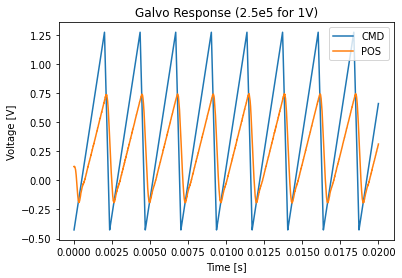

In [651]:
plot_line(t_2_5e5, cmd_2_5e5, freq=2.5e5, title="Galvo Response (2.5e5 for 1V)", ylabel1="CMD", ylabel2="POS", y2=pos_2_5e5)

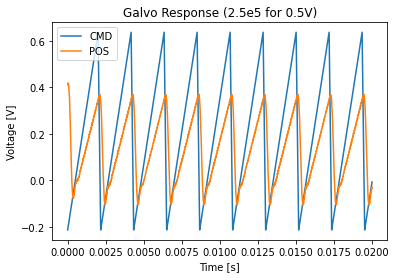

In [652]:
plot_line(t_2_5e5_05, cmd_2_5e5_05, freq=1e5, title="Galvo Response (2.5e5 for 0.5V)", ylabel1="CMD", ylabel2="POS", y2=pos_2_5e5_05)

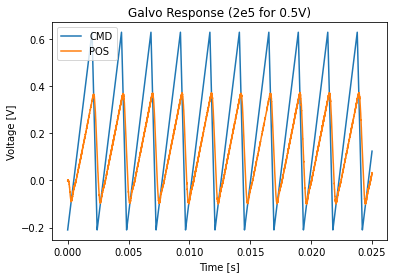

In [673]:
plot_line(t_2e5_05, cmd_2e5_05, freq=2e5, title="Galvo Response (2e5 for 0.5V)", ylabel1="CMD", ylabel2="POS", y2=pos_2e5_05)

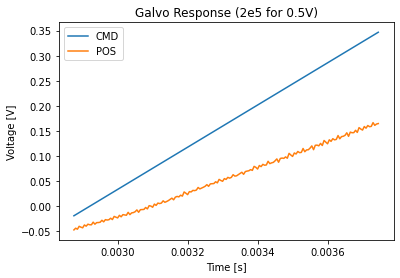

In [660]:
plot_line(t_2e5_05[575:750], cmd_2e5_05[575:750], freq=1e5, title="Galvo Response (2e5 for 0.5V)", ylabel1="CMD", ylabel2="POS", y2=pos_2e5_05[575:750])

Start and Stop on CMD (2e5)
Start Voltage: -0.20167766250000008
Stop Voltage: 0.6283223375


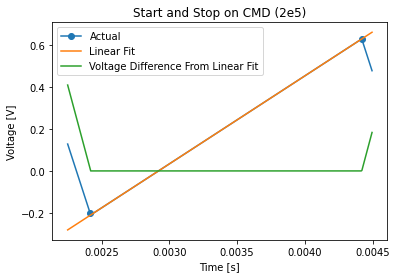

In [674]:
x_2e5_05, old_y_2e5_05, new_y_2e5_05, ystart_2e5_05, yend_2e5_05 = new_line_regression(t_2e5_05, cmd_2e5_05, 575, 800, new_start=450, new_end=900, title="Start and Stop on CMD (2e5)")

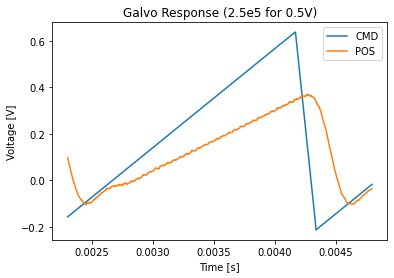

In [680]:
plot_line(t_2_5e5_05[575:1200], cmd_2_5e5_05[575:1200], freq=1e5, title="Galvo Response (2.5e5 for 0.5V)", ylabel1="CMD", ylabel2="POS", y2=pos_2_5e5_05[575:1200])

Start and Stop on CMD (2.5e5)
Start Voltage: -0.09240962141248471
Stop Voltage: 0.3637423530237724


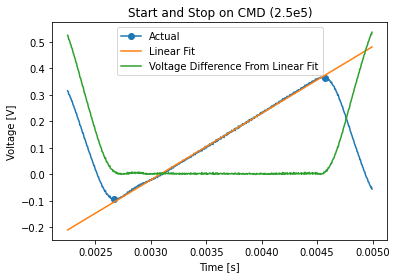

In [676]:
x_2e5_05, old_y_2e5_05, new_y_2e5_05, ystart_2e5_05, yend_2e5_05 = new_line_regression(t_2e5_05, pos_2e5_05, 550, 850, new_start=450, new_end=1000, title="Start and Stop on CMD (2.5e5)")

In [ ]:
x_2e5_05, old_y_2e5_05, new_y_2e5_05, ystart_2e5_05, yend_2e5_05 = new_line_regression(t_2e5_05, pos_2e5_05, 575, 800, new_start=450, new_end=1000, title="Start and Stop on CMD (2.5e5)")